# Day 16 – Implied Volatility Smile & Greeks from Option Chain

Today you'll:
- Pull an option chain (e.g., AAPL) with `yfinance`.
- Compute **mid prices** and invert **Black–Scholes** to get **implied volatilities (IV)**.
- Plot the **IV smile/skew** vs strike.
- Compute and visualize **Greeks** (Delta, Gamma, Vega) by strike.

> If internet/data access fails, the notebook falls back to a **synthetic option surface** so you can still run the full pipeline.


## Learning Objectives
- Understand what **implied volatility** is and why traders look at **smiles/skews**.
- Practice **root-finding** to invert Black–Scholes and obtain IV from market prices.
- Compute **Greeks** and interpret how sensitivity varies by **moneyness** and **strike**.

## Key Concepts
- **Implied Volatility (IV):** the volatility input that makes the Black–Scholes price match the observed market option price.
- **Smile/Skew:** cross‑sectional pattern of IV vs strike (and maturity); reflects market’s perception of tail risk/asymmetry.
- **Greeks:** sensitivities of the option price to inputs (Δ, Γ, Vega, etc.).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from math import log, sqrt, exp
from scipy.stats import norm
from scipy.optimize import brentq

def bs_price(S, K, r, sigma, T, option='call'):
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        if option == 'call':
            return max(0.0, S - K*np.exp(-r*T))
        else:
            return max(0.0, K*np.exp(-r*T) - S)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if option == 'call':
        return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

def bs_greeks(S, K, r, sigma, T, option='call'):
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return {'delta': np.nan, 'gamma': np.nan, 'vega': np.nan}
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    pdf = norm.pdf(d1)
    delta_call = norm.cdf(d1)
    delta_put  = delta_call - 1
    gamma = pdf / (S*sigma*np.sqrt(T))
    vega  = S * pdf * np.sqrt(T)
    if option == 'call':
        return {'delta': delta_call, 'gamma': gamma, 'vega': vega}
    else:
        return {'delta': delta_put, 'gamma': gamma, 'vega': vega}

def implied_vol(price, S, K, r, T, option='call', lo=1e-6, hi=5.0):
    f = lambda sig: bs_price(S, K, r, sig, T, option) - price
    try:
        return brentq(f, lo, hi, maxiter=200, xtol=1e-8)
    except ValueError:
        return np.nan


In [2]:
# Parameters
ticker = "AAPL"
risk_free_rate = 0.035
use_calls = True
min_volume = 10
use_nearest_expiry = True
fallback_if_download_fails = True

print(f"Ticker: {ticker} | Using {'calls' if use_calls else 'puts'} | r={risk_free_rate}")

Ticker: AAPL | Using calls | r=0.035


In [3]:
# Try to fetch real option chain via yfinance; fallback to synthetic if fails
have_real_data = False
df_chain = None
spot = None
expiry_dt = None
T_years = None

try:
    import yfinance as yf
    yt = yf.Ticker(ticker)
    expiries = yt.options
    if expiries and len(expiries) > 0:
        expiry_str = expiries[0] if use_nearest_expiry else expiries[min(1, len(expiries)-1)]
        expiry_dt = pd.to_datetime(expiry_str)
        today = pd.Timestamp.today().normalize()
        T_years = max((expiry_dt - today).days, 1) / 365.0
        spot = yt.history(period="1d")["Close"].iloc[-1]
        chain = yt.option_chain(expiry_str)
        raw = chain.calls if use_calls else chain.puts

        raw = raw.copy()
        def compute_mid(row):
            b = row.get("bid", np.nan)
            a = row.get("ask", np.nan)
            lp = row.get("lastPrice", np.nan)
            if pd.notna(b) and pd.notna(a) and a > 0:
                return 0.5*(b + a)
            return lp
        if "mid" not in raw.columns:
            raw["mid"] = raw.apply(compute_mid, axis=1)

        keep_cols = ['strike', 'lastPrice', 'bid', 'ask', 'mid', 'volume', 'openInterest']
        df_chain = raw[keep_cols].dropna(subset=['strike', 'mid']).copy()
        df_chain = df_chain[df_chain['mid'] > 0]
        df_chain = df_chain[df_chain['volume'].fillna(0) >= min_volume]
        df_chain = df_chain.sort_values('strike')

        if len(df_chain) > 0 and pd.notna(spot) and T_years is not None:
            have_real_data = True
            print(f"Fetched {len(df_chain)} options for expiry {expiry_dt.date()} | Spot ≈ {spot:.2f} | T ≈ {T_years:.3f}y")
        else:
            print("yfinance returned chain but after filtering no rows remained.")
    else:
        print("No expiries returned by yfinance for this ticker.")
except Exception as e:
    print("Data download failed:", repr(e))

if not have_real_data and fallback_if_download_fails:
    np.random.seed(7)
    spot = 100.0
    T_years = 30/365.0
    strikes = np.arange(70, 131, 2, dtype=float)
    base_iv = 0.22
    skew = 0.35 * ((strikes/spot)**-0.65)
    ivs = np.clip(base_iv * (1.0*spot/strikes)**0.25 + 0.1*skew, 0.08, 0.9)
    mids = np.array([bs_price(spot, k, risk_free_rate, sig, T_years, option='call' if use_calls else 'put')
                     for k, sig in zip(strikes, ivs)])
    vol = np.random.randint(50, 800, size=len(strikes))
    oi  = np.random.randint(100, 5000, size=len(strikes))
    df_chain = pd.DataFrame({'strike': strikes, 'mid': mids, 'volume': vol, 'openInterest': oi})
    expiry_dt = pd.Timestamp.today().normalize() + pd.Timedelta(days=int(T_years*365))
    print(f"Using synthetic chain | Spot={spot:.2f} | Expiry={expiry_dt.date()} | Rows={len(df_chain)}")

Fetched 43 options for expiry 2025-08-15 | Spot ≈ 229.46 | T ≈ 0.008y


In [4]:
# Compute IVs and Greeks
option_type = 'call' if use_calls else 'put'
rows = []
for _, row in df_chain.iterrows():
    K = float(row['strike'])
    mid = float(row['mid'])
    iv = implied_vol(mid, spot, K, risk_free_rate, T_years, option=option_type)
    greeks = bs_greeks(spot, K, risk_free_rate, iv if np.isfinite(iv) else np.nan, T_years, option=option_type)
    rows.append({'strike': K, 'mid': mid, 'iv': iv, 'delta': greeks['delta'], 'gamma': greeks['gamma'], 'vega': greeks['vega']})

iv_table = pd.DataFrame(rows).dropna(subset=['iv']).sort_values('strike').reset_index(drop=True)
print(f"Computed IVs for {len(iv_table)} strikes.")
iv_table.head()

Computed IVs for 43 strikes.


,strike,mid,iv,delta,gamma,vega
0,100.0,130.300,4.924773,0.981426,0.000444,0.945875
1,105.0,125.025,4.349048,0.985395,0.000409,0.769954
2,110.0,120.475,4.569995,0.976286,0.000588,1.163067
3,120.0,110.125,3.776687,0.980552,0.000602,0.983573
4,130.0,100.675,3.776808,0.966485,0.000949,1.551172


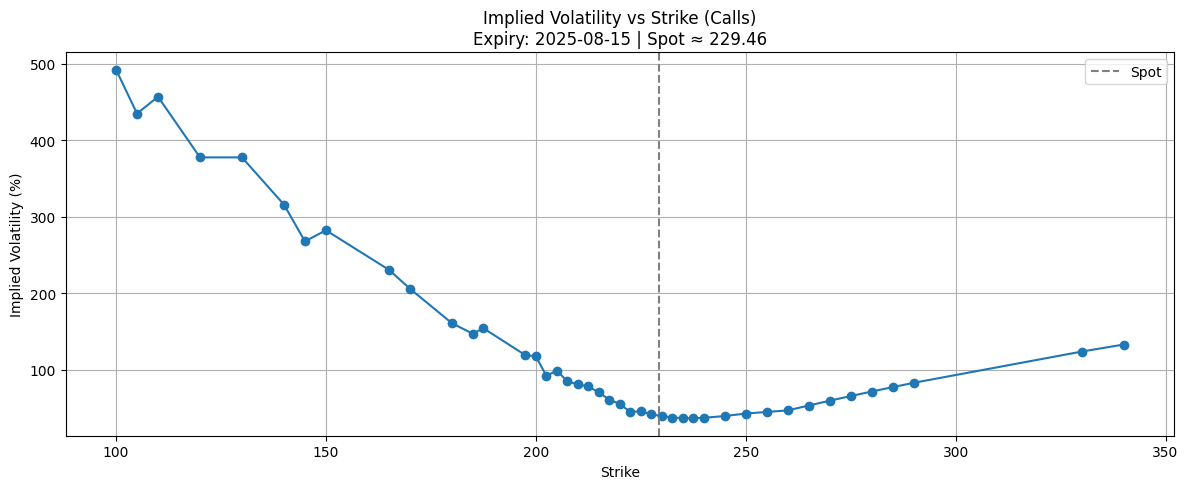

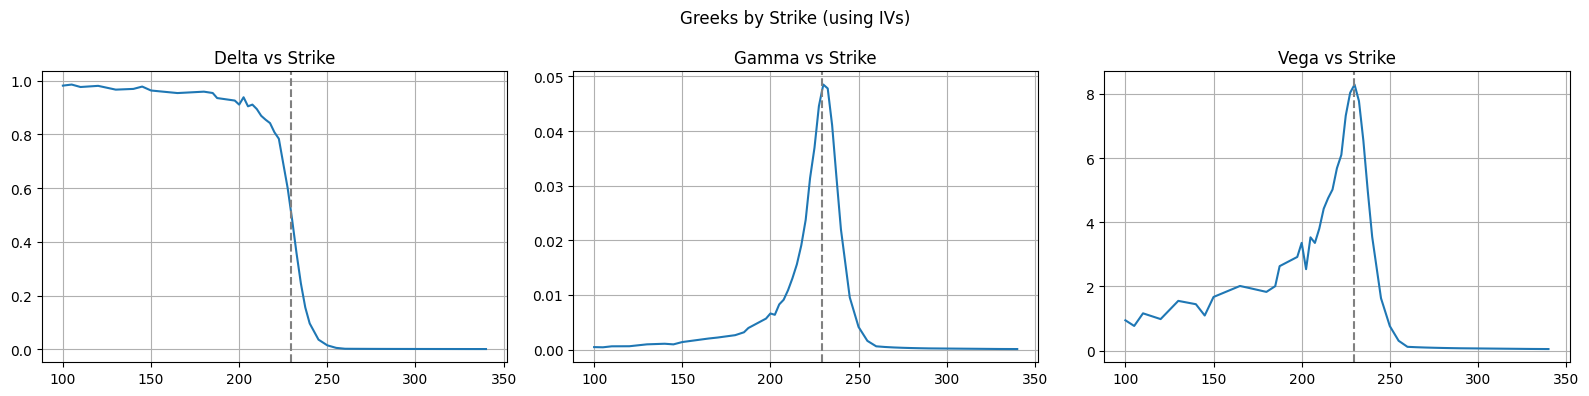

In [5]:
# Plot IV smile
plt.figure(figsize=(12,5))
plt.plot(iv_table['strike'], iv_table['iv']*100.0, marker='o')
plt.axvline(spot, color='gray', linestyle='--', label='Spot')
plt.title(f"Implied Volatility vs Strike ({'Calls' if use_calls else 'Puts'})\nExpiry: {expiry_dt.date()} | Spot ≈ {spot:.2f}")
plt.xlabel('Strike')
plt.ylabel('Implied Volatility (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Greeks
fig, axes = plt.subplots(1, 3, figsize=(16,4), sharex=True)
axes[0].plot(iv_table['strike'], iv_table['delta'])
axes[0].set_title('Delta vs Strike')
axes[0].grid(True)

axes[1].plot(iv_table['strike'], iv_table['gamma'])
axes[1].set_title('Gamma vs Strike')
axes[1].grid(True)

axes[2].plot(iv_table['strike'], iv_table['vega'])
axes[2].set_title('Vega vs Strike')
axes[2].grid(True)

for ax in axes:
    ax.axvline(spot, color='gray', linestyle='--')

fig.suptitle('Greeks by Strike (using IVs)')
plt.tight_layout()
plt.show()

## Interpretation & Next Steps
- **Smile/Skew:** Higher IV at low strikes often reflects equity **crash risk** priced into puts (put‑skew). Calls may show a different shape.
- **Delta/Gamma/Vega:** Expect **Gamma** and **Vega** to peak near **ATM**; **Delta** transitions from ~0 (OTM call) to ~1 (deep ITM call).

**Try:**
- Toggle to `use_calls=False` (puts) and compare skew.
- Change ticker/expiry and study shifts in the smile.
- Fit a simple **SVI** or **SABR** model to the cross‑section of IVs (advanced follow‑up).